In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [80]:
import os
import tqdm
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tskit as tsk
 
from bgspy.models import BGSModel
from bgspy.genome import Genome
from bgspy.utils import bin_chrom, mean_ratio
from bgspy.data import GenomeData, pi_from_pairwise_summaries, trimmed_bins
from bgspy.sim_utils import mutate_simulated_tree
from bgspy.likelihood import FreeMutationModel, SimplexModel, FixedMutationModel

In [3]:
plt.style.use('./buffalo.mplstyle')
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200

In [4]:
g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv", chroms=['chr10'])
#g.load_annot("../data/annotation/conserved_phastcons_thresh0.bed.gz")
#g.load_recmap("../data/annotation/hapmap_genetic_map.txt")

In [5]:
# The B file for the conservation track used in the simulation
pkl_b_file= '../data/bmaps/bgspy/bmap_hg38_sims_10000step_chr10.pkl'
m = BGSModel.load(pkl_b_file)

## Explore one Simulation Tree File

In [69]:
file = '../data/test_trees/mu1e-08_sh0.01/chrombgs_chr10_thresh0_N1000_mu1e-08_sh0.01_chr10_seed3411287642_rep66_treeseq.tree'
#file = '../data/test_trees/N10k/chrombgs_chr10_thresh0_N10k_N10000_mu1e-09_sh0.01_chr10_seed1818839066_rep37_treeseq.tree'
tree = tsk.load(file)
        
# load simulation data into GenomeData object
gd = GenomeData(g)
gd.load_neutral_masks('../data/annotation/neutral_phastcons_genes_with_introns.bed.gz')
gd.load_accessibile_masks('../data/annotation/no_centro.bed')

# mutate the tree sequence -- currently things are not recapitated(!)
gd.load_counts_from_ts(mutate_simulated_tree(tree, rate=1e-7), chrom='chr10')

In [50]:
# how many variants?
np.all(gd.counts['chr10'] > 0, axis=1).sum()

415248

How close are mutation and branch diversity?

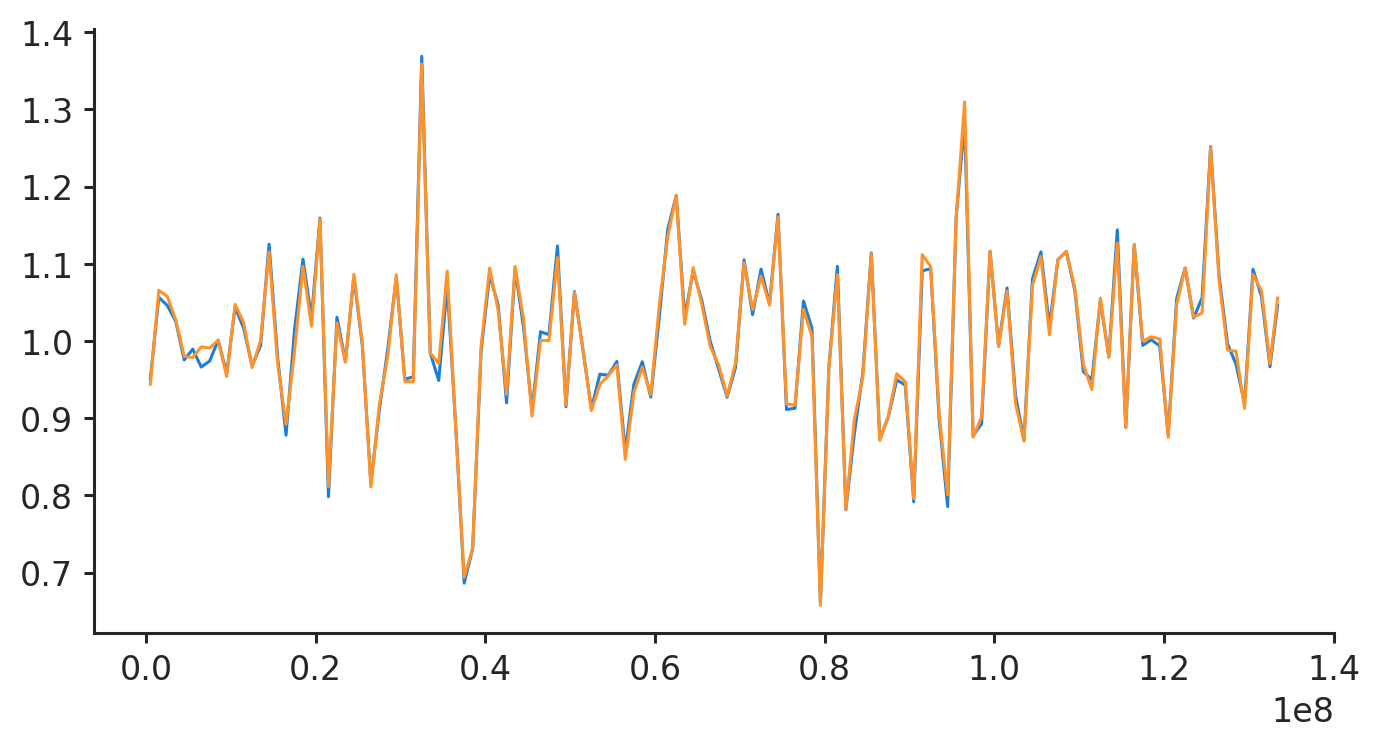

In [70]:
mb_bins = bin_chrom(g.seqlens['chr10'], 1e6)
mb_mps = (mb_bins[1:] + mb_bins[:-1])/2
plt.plot(mb_mps, ratio(tree.diversity(windows=mb_bins, mode='branch')))

bins, pi = gd.bin_pi(width=1e6)
xx, yy = pi['chr10'].pairs
plt.plot(xx, ratio(yy))

## Load a few Tree Files

In [21]:

def load_sim_genomic_data(files, cons_track, access_mask, rate, chrom, winsize, bgs_model):
    sims_gds = []
    Ys = []
    bins = []
    for file in tqdm.tqdm(files):
        tree = tsk.load(os.path.join(tree_dir, file))
        
        # load simulation data into GenomeData object
        gd = GenomeData(g)
        gd.load_neutral_masks(cons_track)
        gd.load_accessibile_masks(access_mask)
        
        # mutate the tree sequence -- currently things are not recapitated(!)
        gd.load_counts_from_ts(mutate_simulated_tree(tree, rate=rate), chrom=chrom)
        sims_gds.append(gd)
        
        # calc Ys
        b, Y = gd.bin_reduce(winsize, merge=True)
        bins.append(b)
        Ys.append(Y)
        
    # note assumes same bins -- TODO verify?
    bins = bins[0]
    B = bgs_model.BScores.bin_means(bins).B[chrom]
    Bp = bgs_model.BpScores.bin_means(bins).B[chrom]
    return sims_gds, bins, Ys, B, Bp

tree_dir = '../data/test_trees/mu1e-08_sh0.01/'
files = os.listdir(tree_dir)

gd, bins, Ys, B, Bp = load_sim_genomic_data(files, 
                                            cons_track='../data/annotation/neutral_phastcons_genes_with_introns.bed.gz', 
                                            access_mask='../data/annotation/no_centro.bed', rate=1e-7, chrom='chr10',
                                            winsize=1e6, bgs_model=m)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:12<00:00, 64.16s/it]


In [22]:
files

['chrombgs_chr10_thresh0_N1000_mu1e-08_sh0.01_chr10_seed4013305247_rep58_treeseq.tree',
 'chrombgs_chr10_thresh0_N1000_mu1e-08_sh0.01_chr10_seed3411287642_rep66_treeseq.tree',
 'chrombgs_chr10_thresh0_N1000_mu1e-08_sh0.01_chr10_seed3308834955_rep22_treeseq.tree']

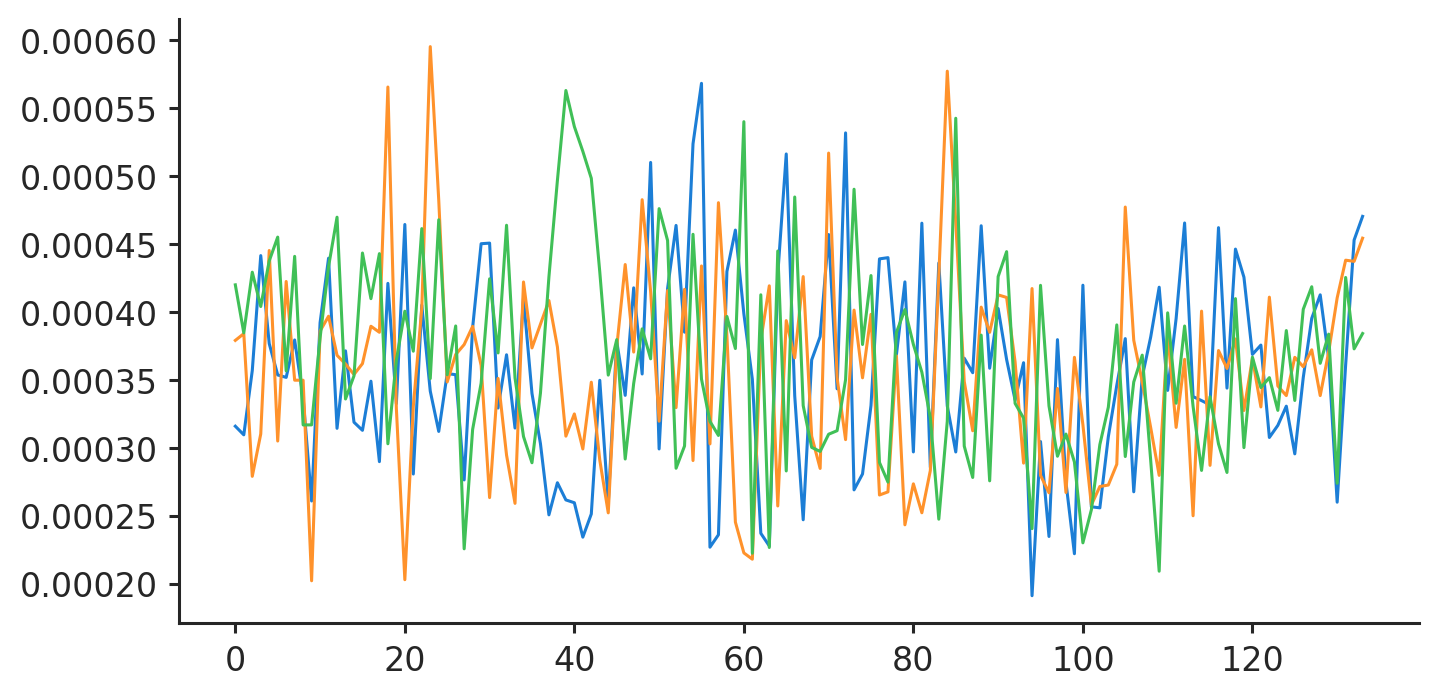

In [23]:
plt.plot(pi_from_pairwise_summaries(Ys[0]))
plt.plot(pi_from_pairwise_summaries(Ys[1]))
plt.plot(pi_from_pairwise_summaries(Ys[2]))

## 

## Load Human Data Data

Load real genomic data for comparison (e.g. to see how sims compare).

In [25]:
hg38_gd = GenomeData(g)
hg38_gd.load_counts_dir('../data/h1kg/hg1k_counts/')
hg38_gd.load_neutral_masks('../data/annotation/neutral_phastcons_genes_with_introns.bed.gz')
hg38_gd.load_accessibile_masks('../data/annotation/no_centro.bed')

In [26]:
hg38_bins, hg38_pi = hg38_gd.bin_pi(width=1e6, filter_neutral=True, filter_accessible=True)

In [49]:
# how many variants?
np.all(hg38_gd.counts['chr10'] > 0, axis=1).sum()

1402597

## Test Model Fits

In [12]:
fmlik_nml = FreeMutationModel(m.w, m.t, Bp, Y=Ys[0])
fmlik_nml.fit(starts=100, ncores=70, algo='NELDERMEAD')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 167.93it/s]


In [13]:
fmlik_nml

MLE (interpolated w): 6 x 7 x 1
  w grid: [1.00e-10 3.16e-10 1.00e-09 3.16e-09 1.00e-08 3.16e-08] (before interpolation)
  t grid: [0.0001   0.000316 0.001    0.00316  0.01     0.0316   0.1     ]

Free-mutation model ML estimates:
negative log-likelihood: 960064017491.6447
π0 = 0.0004101626977217466
W = 
--------
0.14285
0.14285
0.14285
0.142902
0.14285
0.14285
0.14285
--------
μ = 
-----------
7.00037e-10
-----------

In [16]:
slik_nml = SimplexModel(m.w, m.t, Bp, Y=Ys[0])
slik_nml.fit(starts=70, ncores=70, algo='ISRES')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [04:03<00:00,  3.48s/it]


In [18]:
slik_nml

MLE (interpolated w): 6 x 7 x 1
  w grid: [1.00e-10 3.16e-10 1.00e-09 3.16e-09 1.00e-08 3.16e-08] (before interpolation)
  t grid: [0.0001   0.000316 0.001    0.00316  0.01     0.0316   0.1     ]

Simplex model ML estimates:
negative log-likelihood: 960064013955.7792
π0 = 0.0004100993263097391
μ = 1.0008264865969491e-10
W = 
--------  -----
0.0001    0.315
0.000316  0.018
0.001     0.02
0.00316   0.033
0.01      0.238
0.0316    0.316
0.1       0.06
--------  -----

In [17]:
flik_nml = FixedMutationModel(m.w, m.t, Bp, Y=Ys[0])
flik_nml.fit(mu=1e-8, starts=100, ncores=70, algo='ISRES')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:18<00:00,  3.19s/it]


In [19]:
flik_nml

MLE (interpolated w): 6 x 7 x 1
  w grid: [1.00e-10 3.16e-10 1.00e-09 3.16e-09 1.00e-08 3.16e-08] (before interpolation)
  t grid: [0.0001   0.000316 0.001    0.00316  0.01     0.0316   0.1     ]

Fixed-Mutation Simplex model ML estimates:
negative log-likelihood: 960118862761.0024
π0 = 0.0004146184542507134
μ = 1e-08 (fixed)
W = 
--------  -----
0.0001    0.881
0.000316  0.01
0.001     0.01
0.00316   0.01
0.01      0.01
0.0316    0.01
0.1       0.069
--------  -----

In [ ]:
real_theta = np.array([2e-4, 0, 0, 0, 0, 1, 0, 0])
real_theta.size == m.t.size + 2

In [ ]:
m.BpScores

In [ ]:
model

In [24]:
flik_nml = FixedMutationModel(m.w, m.t, Bp, Y=Ys[0])
flik_nml.fit(mu=1e-8, starts=70, ncores=70, algo='ISRES')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [03:08<00:00,  2.69s/it]


In [29]:
flik_nml

MLE (interpolated w): 6 x 7 x 1
  w grid: [1.00e-10 3.16e-10 1.00e-09 3.16e-09 1.00e-08 3.16e-08] (before interpolation)
  t grid: [0.0001   0.000316 0.001    0.00316  0.01     0.0316   0.1     ]

Fixed-Mutation Simplex model ML estimates:
negative log-likelihood: 851145270400.9254
π0 = 0.0003879326378457048
μ = 1e-08 (fixed)
W = 
--------  -----
0.0001    0
0.000316  0.589
0.001     0.411
0.00316   0
0.01      0
0.0316    0
0.1       0
--------  -----

In [75]:
flik_nml.mle_W.reshape(m.t.size, 1)

array([[8.88576583e-10],
       [5.88995930e-01],
       [4.11004056e-01],
       [1.74845711e-11],
       [3.73387376e-09],
       [5.73324922e-09],
       [3.07051538e-09]])

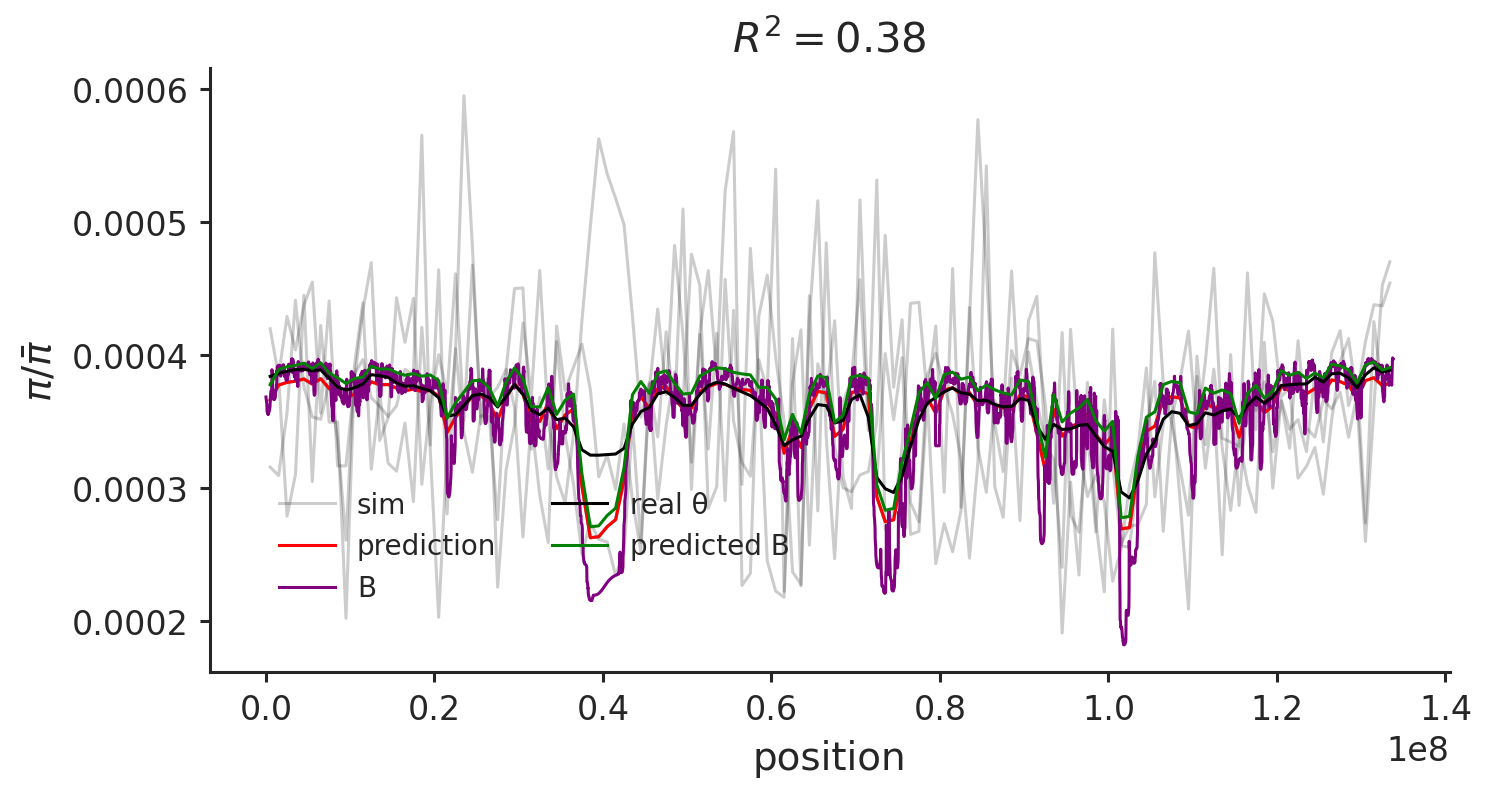

In [78]:

model = flik_nml


for i, Y in enumerate(Ys):
    midpoints = [(s+e)/2 for c, s, e in bins.flat]
    lab = 'sim' if i == 0 else None
    plt.plot(midpoints, pi_from_pairwise_summaries(Y), label=lab, c='k', alpha=0.2)


for i in range(10):
    plt.plot(midpoints, model.predict(optim=i), c='0.44', alpha=0.1)
    
plt.plot(midpoints, model.predict(), c='r', label='prediction')

x, y = m.BpScores.pairs('chr10', 1e-8, 1e-3)
plt.plot(x, 4e-4*y, label='B', c='purple')


plt.plot(midpoints, model.predict(theta=np.array([4e-4, 0, 0, 0, 0, 1, 0, 0])), c='k', label='real θ')
plt.plot(midpoints, model.predict(theta=np.array([4e-4, 0, 0.589, 0.411, 0, 0, 0, 0])), c='green', label='predicted B')
#plt.plot((midpoints, ratio(predict_simplex(np.array([2e-4, 1e-8, 0, 0, 0, 0, 1, 0, 0]), Bp, m.w))))

plt.ylabel("$\pi/\\bar{\pi}$")
plt.xlabel("position")
plt.title(f"$R^2 = {model.R2():.2}$")
plt.legend(loc='lower left', ncol=2)

This seems to show a serious oddity in the simulations: there is a great deal more variance in any one replicate than we possibly see in real data.

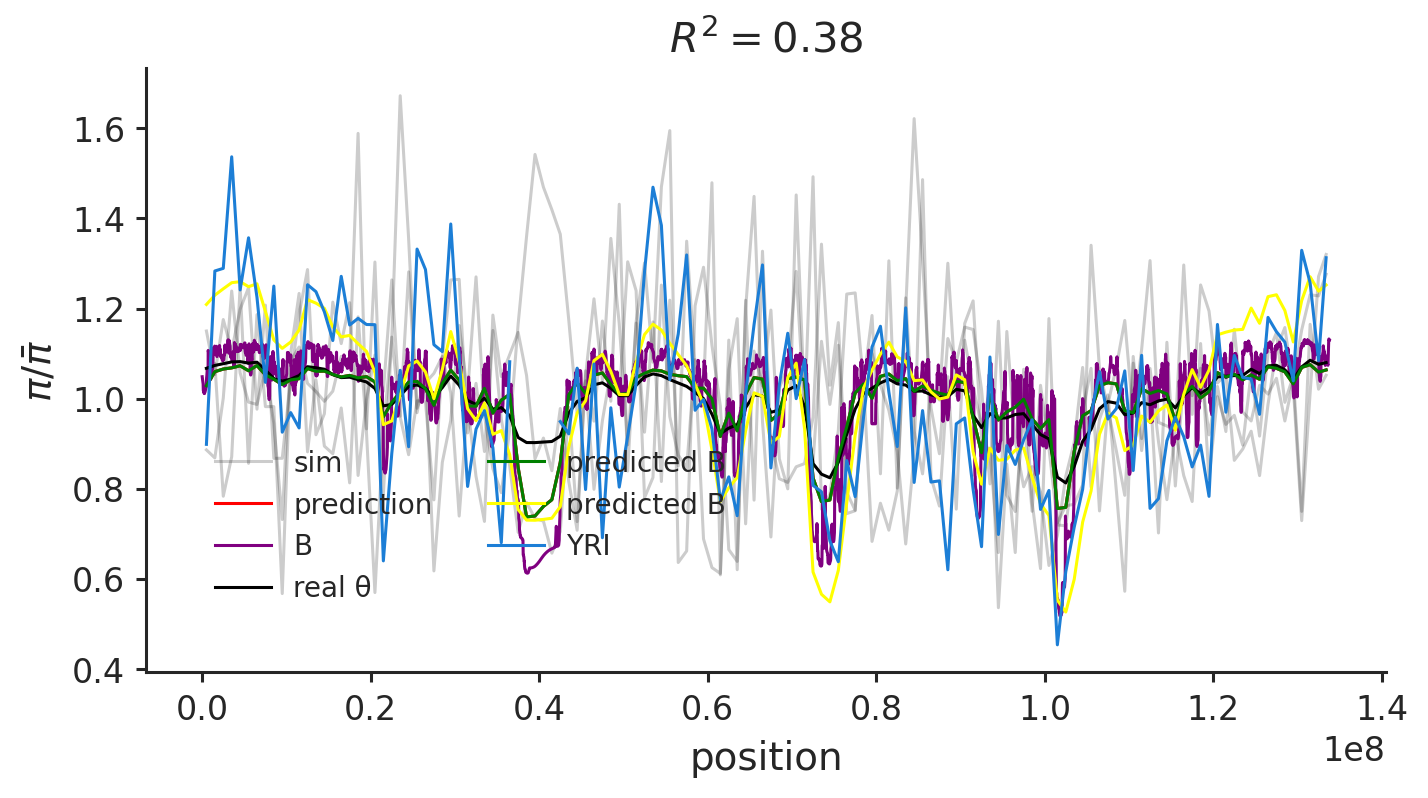

In [84]:

model = flik_nml


for i, Y in enumerate(Ys):
    midpoints = [(s+e)/2 for c, s, e in bins.flat]
    lab = 'sim' if i == 0 else None
    plt.plot(midpoints, mean_ratio(pi_from_pairwise_summaries(Y)), label=lab, c='k', alpha=0.2)


for i in range(10):
    plt.plot(midpoints, mean_ratio(model.predict(optim=i)), c='0.44', alpha=0.1)
    
plt.plot(midpoints, mean_ratio(model.predict()), c='r', label='prediction')

x, y = m.BpScores.pairs('chr10', 1e-8, 1e-3)
plt.plot(x, mean_ratio(y), label='B', c='purple')



plt.plot(midpoints, mean_ratio(model.predict(theta=np.array([4e-4, 0, 0, 0, 0, 1, 0, 0]))), c='k', label='real θ')
plt.plot(midpoints, mean_ratio(model.predict(theta=np.array([4e-4, 0, 0.589, 0.411, 0, 0, 0, 0]))), c='green', label='predicted B')
plt.plot(midpoints, mean_ratio(model.predict(theta=np.array([4e-4, 0, 0, 0, 0, 1, 0, 0]), mu=3.16e-8)), c='yellow', label='predicted B')

#plt.plot((midpoints, ratio(predict_simplex(np.array([2e-4, 1e-8, 0, 0, 0, 0, 1, 0, 0]), Bp, m.w))))

xx, yy = hg38_pi['chr10'].pairs
plt.plot(xx, mean_ratio(yy), label='YRI')
plt.ylabel("$\pi/\\bar{\pi}$")
plt.xlabel("position")
plt.title(f"$R^2 = {model.R2():.2}$")
plt.legend(loc='lower left', ncol=2)

In [ ]:
fmlik_nml = FreeMutationModel(m.w, m.t, Bp, Y=Ys[0])
fmlik_nml.fit(starts=100, ncores=70, algo='NELDERMEAD')

In [ ]:
fmlik_nml

In [ ]:

model = fmlik_nml


for Y in Ys:
    midpoints = [(s+e)/2 for c, s, e in bins.flat]
    plt.plot(midpoints, pi_from_pairwise_summaries(Y), label='sim')


for i in range(10):
    plt.plot(midpoints, model.predict(optim=i), c='0.44', alpha=0.1)
    
plt.plot(midpoints, model.predict(), c='r', label='prediction')

x, y = m.BpScores.pairs('chr10', 1e-8, 1e-3)
plt.plot(x, 4e-4*y, label='B', c='purple')


plt.plot(midpoints, model.predict(theta=np.array([4.5e-4, 0, 0, 0, 0, 1, 0, 0])), c='k', label='real θ')
#plt.plot((midpoints, ratio(predict_simplex(np.array([2e-4, 1e-8, 0, 0, 0, 0, 1, 0, 0]), Bp, m.w))))

plt.ylabel("$\pi/\\bar{\pi}$")
plt.xlabel("position")
plt.title(f"$R^2 = {model.R2():.2}$")
plt.legend(loc='lower left', ncol=2)

In [ ]:
fmlik_nml2 = FreeMutationModel(m.w, m.t, Bp, Y=Ys[2])
fmlik_nml2.fit(starts=100, ncores=70, algo='NELDERMEAD')

In [ ]:
midpoints = [(s+e)/2 for c, s, e in bins.flat]
plt.plot(midpoints, pi_from_pairwise_summaries(Ys[2]))
plt.plot(midpoints, fmlik_nml2.predict(), c='r', label='prediction')


In [ ]:
from bgspy.likelihood import predict_simplex

plt.plot(midpoints, pi_from_pairwise_summaries(trim_Y), label='sim')

plt.plot(midpoints, predict_simplex(np.array([2.4e-4, 1e-8, 0, 0, 0, 1, 0, 0, 0]), Bp, m.w))

In [ ]:
slik_nml

In [ ]:
W = lik_nml.optim.thetas_[:100].mean(axis=0)[1:].reshape((5, 3))
W

In [ ]:
lik_nml.R2()

In [ ]:
lik_nml

In [ ]:
plt.scatter(pi_from_pairwise_summaries(trim_Y), lik_nml.predict())
plt.axline((0, 0), slope=1, c='r')